# Findig the peak in the receivers

This notebook uses the water tank model from the previous notebook. The size of the receivers and sources width is fixed and from the echo the found point can be shown.

### Plot functions with save

In [2]:
import numpy as np
try:
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    mpl.rc('font', size=16)
    mpl.rc('figure', figsize=(8, 6))
except:
    plt = None
    cm = None

def plot_velocity_save(model, source=None, receiver=None, colorbar=True, cmap="jet", name=None):
    """
    Plot a two-dimensional velocity field from a seismic `Model`
    object. Optionally also includes point markers for sources and receivers.

    Parameters
    ----------
    model : Model
        Object that holds the velocity model.
    source : array_like or float
        Coordinates of the source point.
    receiver : array_like or float
        Coordinates of the receiver points.
    colorbar : bool
        Option to plot the colorbar.
    """
    domain_size = 1.e-3 * np.array(model.domain_size)
    extent = [model.origin[0], model.origin[0] + domain_size[0],
              model.origin[1] + domain_size[1], model.origin[1]]

    slices = tuple(slice(model.nbl, -model.nbl) for _ in range(2))
    if getattr(model, 'vp', None) is not None:
        field = model.vp.data[slices]
    else:
        field = model.lam.data[slices]
    plot = plt.imshow(np.transpose(field), animated=True, cmap=cmap,
                      vmin=np.min(field), vmax=np.max(field),
                      extent=extent)
    plt.xlabel('X position (km)')
    plt.ylabel('Depth (km)')

    # Plot source points, if provided
    if receiver is not None:
        plt.scatter(1e-3*receiver[:, 0], 1e-3*receiver[:, 1],
                    s=25, c='green', marker='D')

    # Plot receiver points, if provided
    if source is not None:
        plt.scatter(1e-3*source[:, 0], 1e-3*source[:, 1],
                    s=25, c='red', marker='o')

    # Ensure axis limits
    plt.xlim(model.origin[0], model.origin[0] + domain_size[0])
    plt.ylim(model.origin[1] + domain_size[1], model.origin[1])

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(plot, cax=cax)
        cbar.set_label('Velocity (km/s)')
    if name:
        plt.savefig(name + ".pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
def plot_shotrecord_save(rec, model, t0, tn, colorbar=True, name=None):
    """
    Plot a shot record (receiver values over time).

    Parameters
    ----------
    rec :
        Receiver data with shape (time, points).
    model : Model
        object that holds the velocity model.
    t0 : int
        Start of time dimension to plot.
    tn : int
        End of time dimension to plot.
    """
    scale = np.max(rec) / 10.
    extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[0],
              1e-3*tn, t0]

    plot = plt.imshow(rec, vmin=-scale, vmax=scale, cmap=cm.gray, extent=extent)
    plt.xlabel('X position (km)')
    plt.ylabel('Time (s)')

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(plot, cax=cax)
    if name:
        plt.savefig(name + ".pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [4]:
import numpy as np
import numpy.typing as npt
import math
import matplotlib.pyplot as plt 
from examples.seismic import Receiver
from examples.seismic import RickerSource
from examples.seismic import Model, plot_velocity, TimeAxis
from devito import TimeFunction
from devito import Eq, solve
from devito import Operator
from devito import ConditionalDimension
from examples.seismic import plot_shotrecord
from scipy.signal import find_peaks, peak_prominences, peak_widths


In [5]:
def srcPositions(cx: float, cy:float, alpha:float, ns:int, sdist:float) -> np.typing.NDArray:
    assert alpha >= 0 and alpha < 180
    assert ns > 0
    dx = sdist * math.sin(math.pi / 180 * alpha)
    dy = sdist * math.cos(math.pi / 180 * alpha)

    res = np.zeros((ns, 2))
    res[:, 0] = np.linspace(cx - dx * (ns - 1) / 2, cx + dx * (ns - 1) / 2, num = ns)
    res[:, 1] = np.linspace(cy - dy * (ns - 1) / 2, cy + dy * (ns - 1) / 2, num = ns)
    return res



## Grid setup
Set the velocity model and the global parameters for the water tank

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


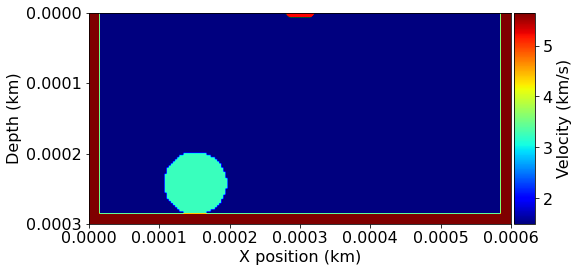

Operator `Kernel` ran in 0.10 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.07259400000000028, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.006132999999999993, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.004680000000000001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [9]:
nx = 201
nz = 101
nb = 10
shape = (nx, nz)
spacing = (.003, .003) #60x30 cm
origin = (0., 0.)
v_water = 1.5 # v in distilled water 1496.7 m/s
v_glass = 5.64 # v in glass 5640 m/s
v_obj = 3.24 # v in gold 3240 m/s
glass = 5 # size of the glass
# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :] = v_water 
v[:, -glass:] = v_glass
v[:glass, :] = v_glass
v[-glass:, :] = v_glass
# Define an object's velocity profile
r = 15
a, b = shape[0] / 4, shape[1] - r - glass
y, x = np.ogrid[-a:shape[0]-a, -b:shape[1]-b]
v[x*x + y*y <= r*r] = v_obj

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = .5  # Simulation lasts tn milliseconds
dt = model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

f0 = 5000  # Source peak frequency is 5 MHz (5000 kHz)
ns = 128; # number of sources
nr = ns; # number of receivers
depth = .0001
width = .03 # 3 cm is the widht of the sources
source_distance = width / ns
# alpha = 65 # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
# cx = model.domain_size[0] * 0.5
# cy = (ns - 1) / 4 * source_distance
# pos = srcPositions(cx, cy, alpha, ns, source_distance)
src = RickerSource(
    name='src',
    grid=model.grid,
    f0=f0,
    time_range=time_range,
    npoint=ns)

for i in range(ns):
    src.coordinates.data[i, :] = np.array(
        model.domain_size) * .5 + (i - (ns - 1) / 2) * source_distance
src.coordinates.data[:, -1] = depth

# src.coordinates.data[:] = pos[:]


rec = Receiver(
    name='rec',
    grid=model.grid,
    npoint=nr,
    time_range=time_range) 

for i in range(nr):
    rec.coordinates.data[i, :] = np.array(
        model.domain_size) * .5 + (i - (nr - 1) / 2) * source_distance
rec.coordinates.data[:, -1] = depth

# rec.coordinates.data[:] = pos[:]

plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=nt - 2, dt=model.critical_dt)

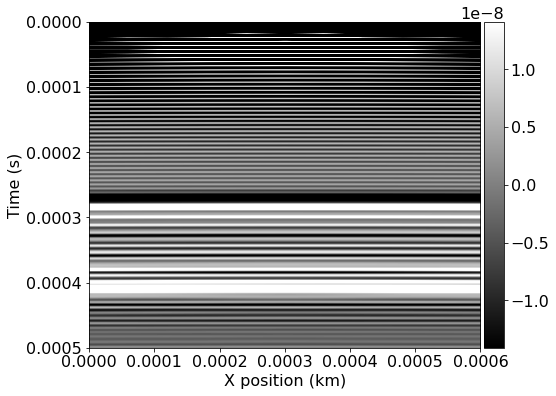

In [82]:
plot_shotrecord(rec.data, model, t0, tn)

123


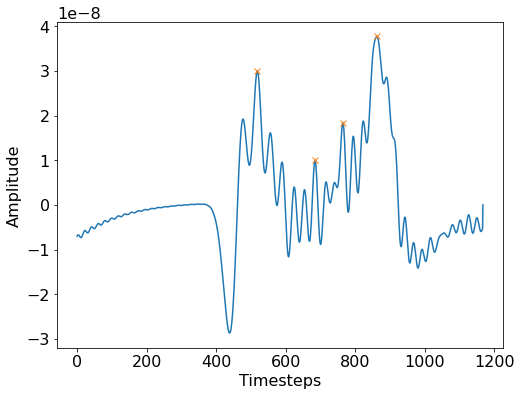

In [66]:
cut = round(width / 1000 / v_water * 1000 * 2 / dt)
print(cut)
x = rec.data[3 * cut:, 1]
peaks, _ = find_peaks(x)
prominences = peak_prominences(x, peaks)[0]
true_peaks = peaks[(prominences - np.average(prominences)) > np.std(prominences)]
plt.xlabel("Timesteps")
plt.ylabel("Amplitude")
plt.plot(x)
plt.plot(true_peaks, x[true_peaks], "x")
plt.savefig("/home/hajta2/left_signal.pdf", format="pdf", bbox_inches="tight")
plt.show()

123


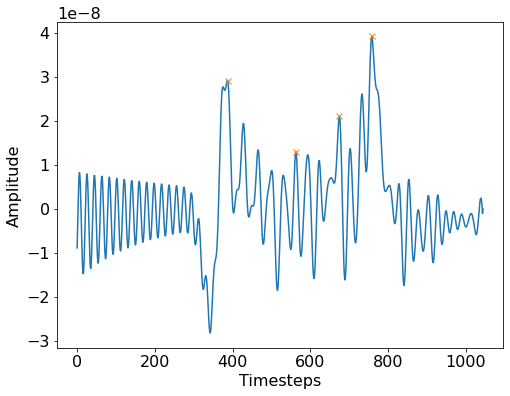

21.4717729097174


In [89]:
cut = round(width / 1000 / v_water * 1000 * 2 / dt)
print(cut)
x = rec.data[4 * cut:, 68]
peaks, _ = find_peaks(x)
prominences = peak_prominences(x, peaks)[0]
true_peaks = peaks[(prominences - np.average(prominences)) > np.std(prominences)]
plt.xlabel("Timesteps")
plt.ylabel("Amplitude")
plt.plot(x)
plt.plot(true_peaks, x[true_peaks], "x")
plt.savefig("/home/hajta2/left_signal.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(objDistance(rec.data[:,68],dt,width,v_water))

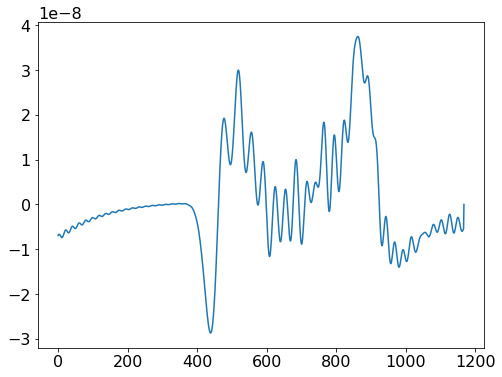

In [60]:
x = rec.data[3*cut:, 0]
y = rec.data[3*cut:, -1]
z = np.average(rec.data[3*cut:, :], axis = 1)
plt.plot(x)
plt.show()

1411.5


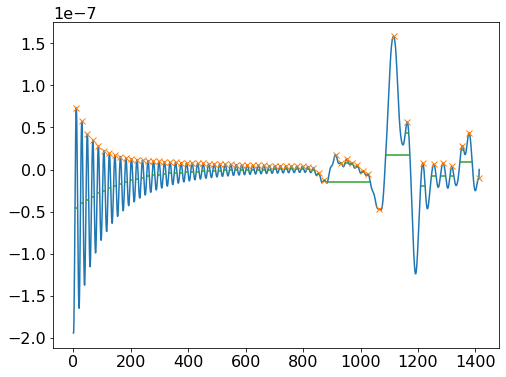

In [7]:
cut = round(width / 1000 / v_water * 1000 * 2 / dt)
x = rec.data[cut:, 68]
peaks, _ = find_peaks(x)
results_half = peak_widths(x, peaks, rel_height=0.5)
#true_peaks = peaks[(prominences - np.average(prominences)) > np.std(prominences)]
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.hlines(*results_half[1:], color="C2")
print(np.max(results_half[1:]))
plt.show()